# 📊 Bank Earnings Sentiment & Topic Analysis

This notebook analyzes the sentiment and latent topics from earnings call transcripts.

## 📥 Load Data

In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("transcript_sentences.csv")
df['quarter_year'] = df['quarter'] + " " + df['year'].astype(str)
df = df.dropna(subset=['sentence'])  # Remove empty rows


## 😊 Sentiment Analysis

In [11]:

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['sentence'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0.2 else 'negative' if x < -0.2 else 'neutral')


[nltk_data] Downloading package vader_lexicon to C:\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


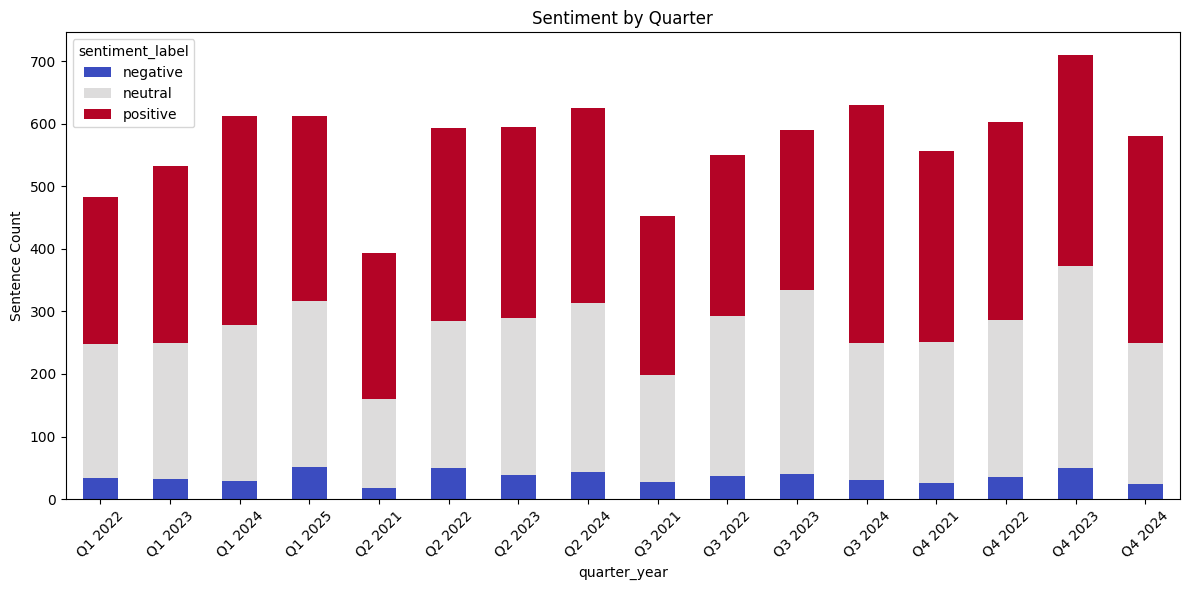

In [12]:

# Sentiment over time
sentiment_summary = df.groupby(['quarter_year', 'sentiment_label']).size().unstack(fill_value=0)

sentiment_summary.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm', title='Sentiment by Quarter')
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🧠 Topic Modeling (LDA)

In [13]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['sentence'].astype(str))

lda = LatentDirichletAllocation(n_components=5, random_state=0)
topics = lda.fit_transform(X)
df['topic'] = topics.argmax(axis=1)


In [14]:

# Show top words per topic
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


Topic 0: clients, client, growth, services, banking, investment, new, balance, retail, bank
Topic 1: just, think, question, going, mark, come, different, like, important, look
Topic 2: ve, capital, year, think, term, line, transformation, expect, got, continue
Topic 3: credit, slide, quarter, results, performance, consumer, environment, business, good, drivers
Topic 4: billion, driven, year, quarter, revenues, net, income, expenses, higher, offset


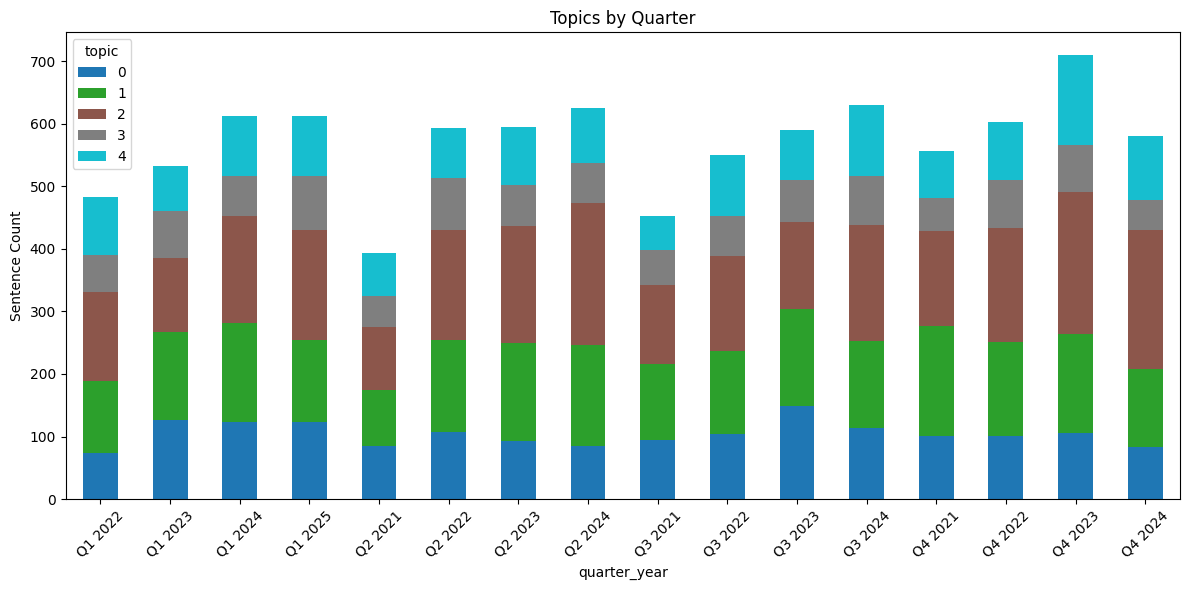

In [15]:

# Topic distribution
topic_dist = df.groupby(['quarter_year', 'topic']).size().unstack(fill_value=0)
topic_dist.plot(kind='bar', stacked=True, colormap='tab10', figsize=(12,6), title="Topics by Quarter")
plt.ylabel("Sentence Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 🏛️ Regulatory Topic Mapping by LDA Topic

C:\Users\astri\AppData\Local\Temp\ipykernel_36704\3660771152.py:24: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  plt.tight_layout()
C:\Users\astri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


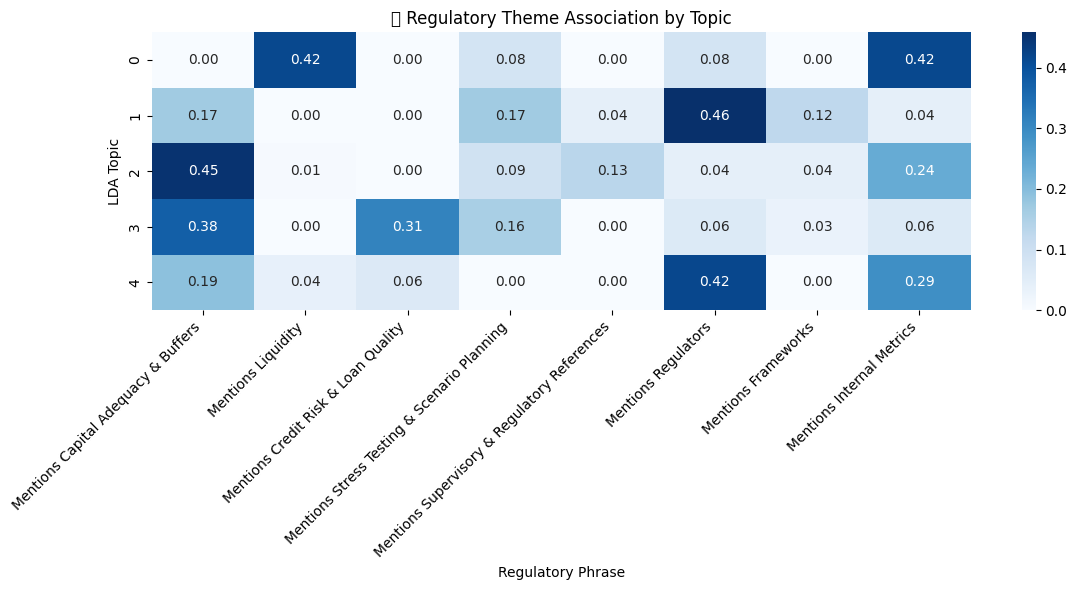

In [16]:

# Regulatory mentions by topic
reg_cols = [col for col in df.columns if col.startswith("Mentions ")]
df['topic'] = df['topic'].astype(int)

topic_reg_summary = (
    df.groupby("topic")[reg_cols]
    .apply(lambda group: group.eq("Yes").sum())
    .sort_index()
)

# Normalize by row for proportion
topic_reg_percent = topic_reg_summary.div(topic_reg_summary.sum(axis=1), axis=0)

# Heatmap of regulatory-topic associations
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(topic_reg_percent, annot=True, cmap="Blues", fmt=".2f")
plt.title("📌 Regulatory Theme Association by Topic")
plt.ylabel("LDA Topic")
plt.xlabel("Regulatory Phrase")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Sentiment per Regulatory Topic per Quarter

In [17]:
reg_sent = df[df[reg_cols].eq("Yes").any(axis=1)].copy()
reg_sent_summary = (
    reg_sent.groupby(['quarter_year'] + reg_cols)['sentiment_label']
    .value_counts()
    .unstack(fill_value=0)
).reset_index()

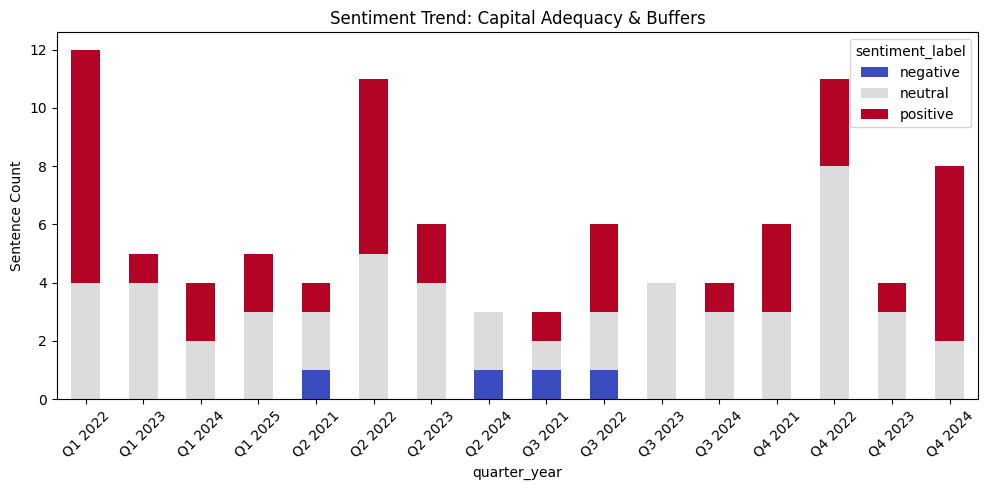

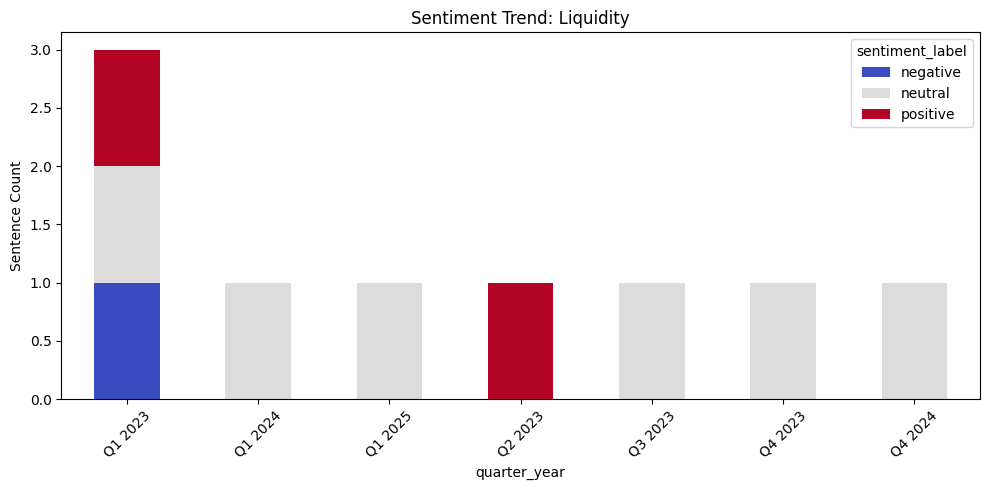

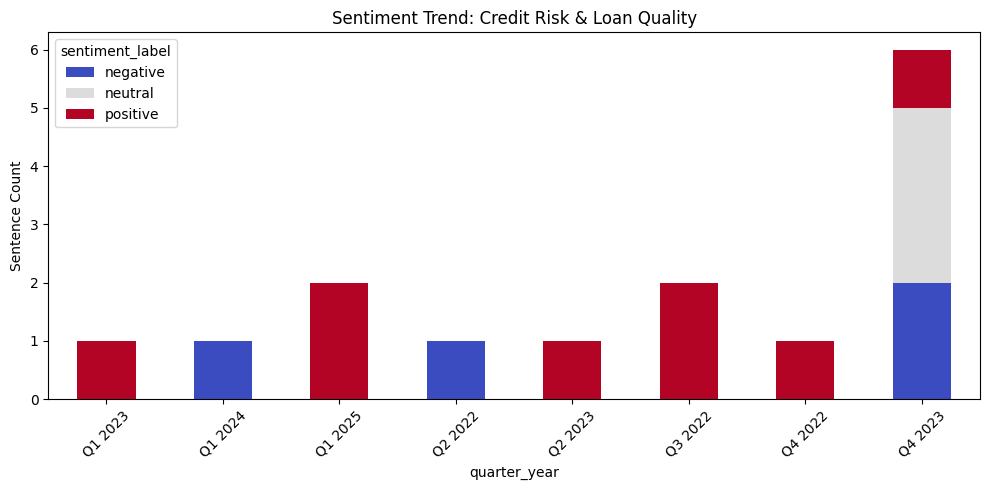

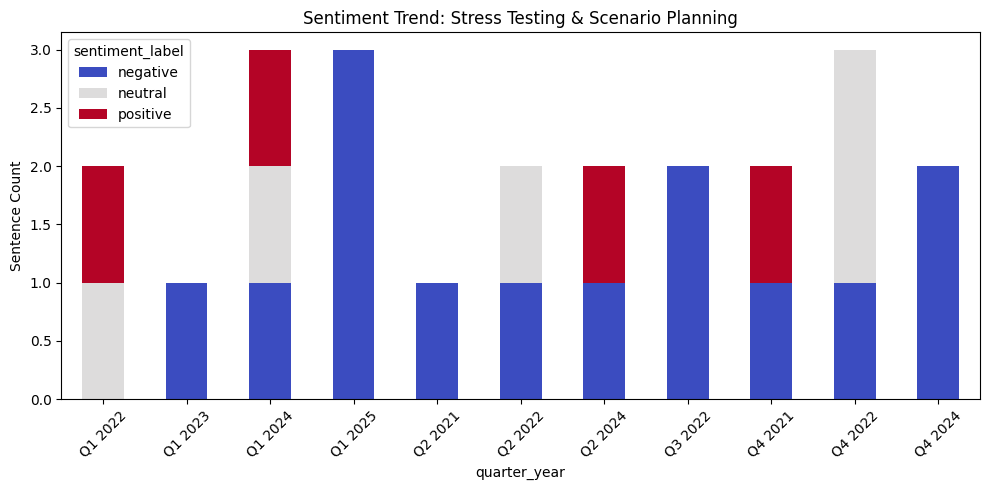

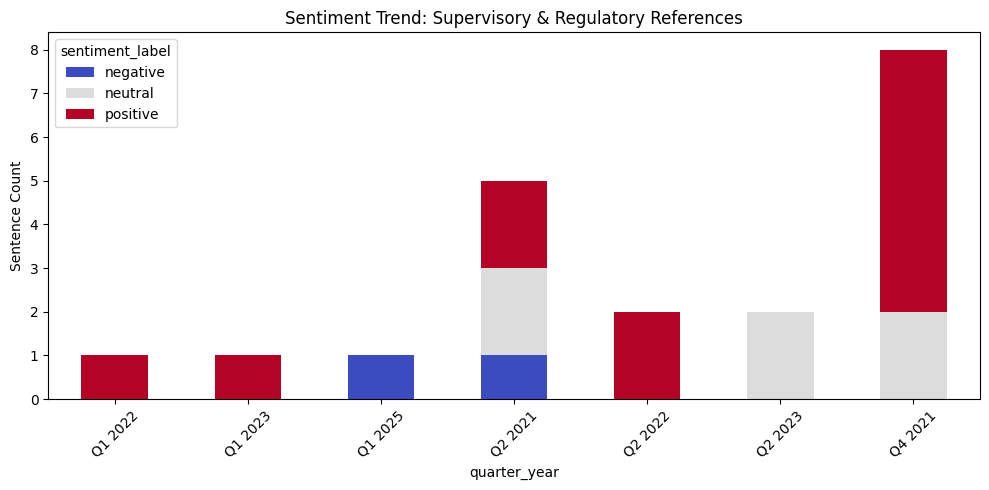

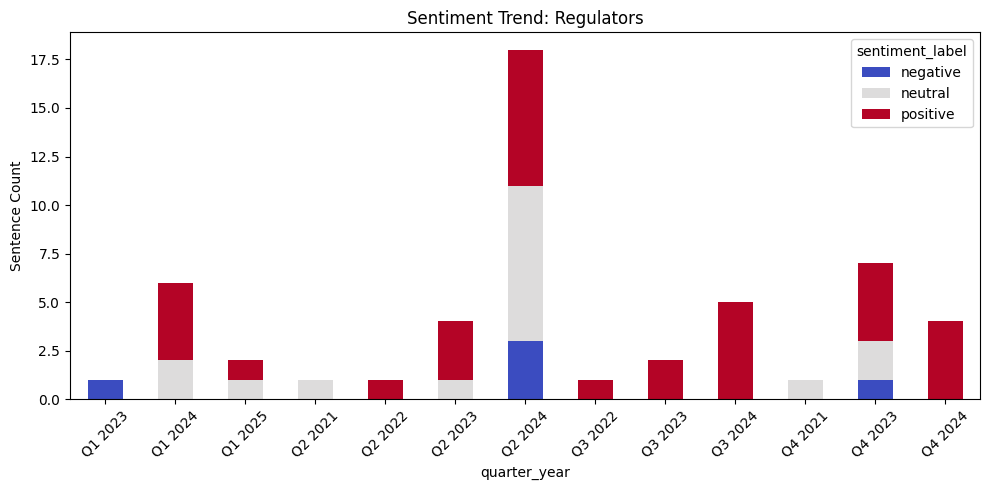

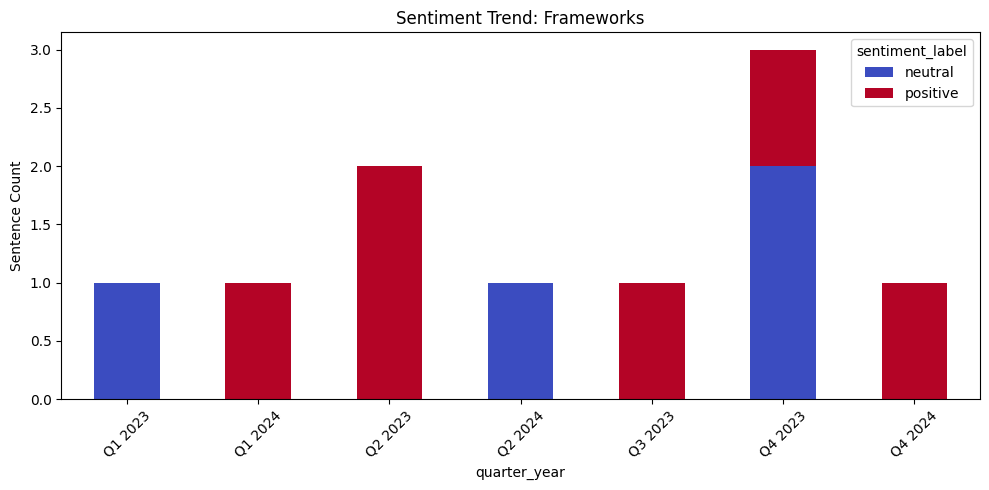

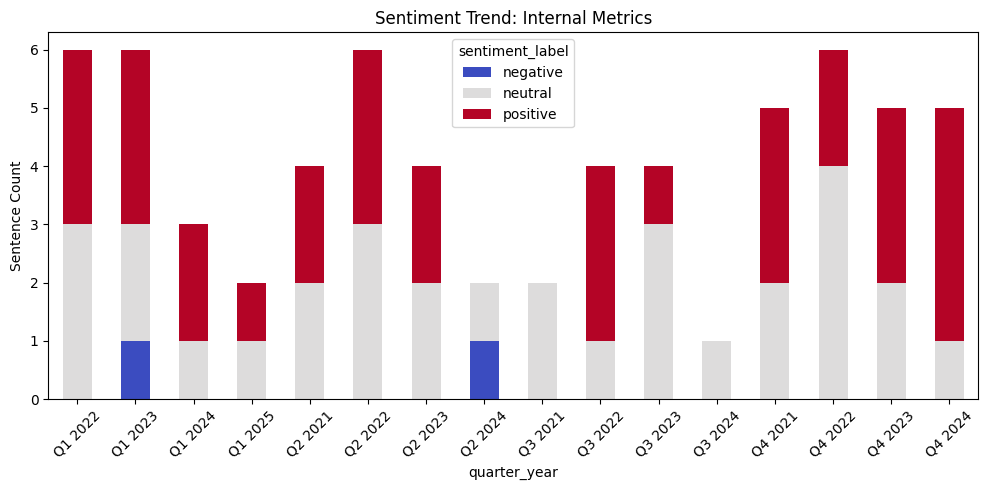

In [18]:
# For each regulatory column, plot sentiment over quarters
for reg_col in reg_cols:
    subset = reg_sent[reg_sent[reg_col] == "Yes"]
    if subset.empty:
        continue

    sentiment_trend = (
        subset.groupby(['quarter_year'])['sentiment_label']
        .value_counts()
        .unstack()
        .fillna(0)
    )

    sentiment_trend.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='coolwarm')
    plt.title(f"Sentiment Trend: {reg_col.replace('Mentions ', '')}")
    plt.ylabel("Sentence Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Topic Sentiment by Speaker Type (Citi vs Investors) 

In [19]:
topic_sent_split = (
    df.groupby(['quarter_year', 'is_citi_member', 'topic'])['sentiment_label']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

In [20]:
# Pivot for comparison
topic_cmp = topic_sent_split.pivot_table(
    index=['quarter_year', 'topic'],
    columns='is_citi_member',
    values=['positive', 'neutral', 'negative'],
    fill_value=0
)

In [21]:
# Flatten MultiIndex columns
topic_cmp.columns = ['_'.join(col).strip() for col in topic_cmp.columns.values]
topic_cmp.reset_index(inplace=True)

In [22]:
# --- 3. Add contradiction flag ---
def detect_contradiction(row):
    if row.get('positive_Yes', 0) > row.get('positive_No', 0) and row.get('negative_No', 0) > row.get('negative_Yes', 0):
        return "Citi Positive, Investor Negative"
    elif row.get('negative_Yes', 0) > row.get('negative_No', 0) and row.get('positive_No', 0) > row.get('positive_Yes', 0):
        return "Citi Negative, Investor Positive"
    return "No Strong Contradiction"

topic_cmp['sentiment_contradiction'] = topic_cmp.apply(detect_contradiction, axis=1)


In [24]:
topic_cmp.sort_values(by='quarter_year').head(10)

,quarter_year,topic,negative_no,negative_yes,neutral_no,neutral_yes,positive_no,positive_yes,sentiment_contradiction
0,Q1 2022,0,1,2,9,17,4,40,No Strong Contradiction
1,Q1 2022,1,3,1,30,33,8,40,No Strong Contradiction
2,Q1 2022,2,0,12,17,44,7,63,No Strong Contradiction
3,Q1 2022,3,0,7,2,24,2,25,No Strong Contradiction
4,Q1 2022,4,1,7,4,34,4,42,No Strong Contradiction
9,Q1 2023,4,1,6,3,27,1,34,No Strong Contradiction
7,Q1 2023,2,2,6,17,32,9,52,No Strong Contradiction
8,Q1 2023,3,1,5,5,22,9,34,No Strong Contradiction
5,Q1 2023,0,1,2,11,37,5,70,No Strong Contradiction
6,Q1 2023,1,4,4,30,33,20,50,No Strong Contradiction


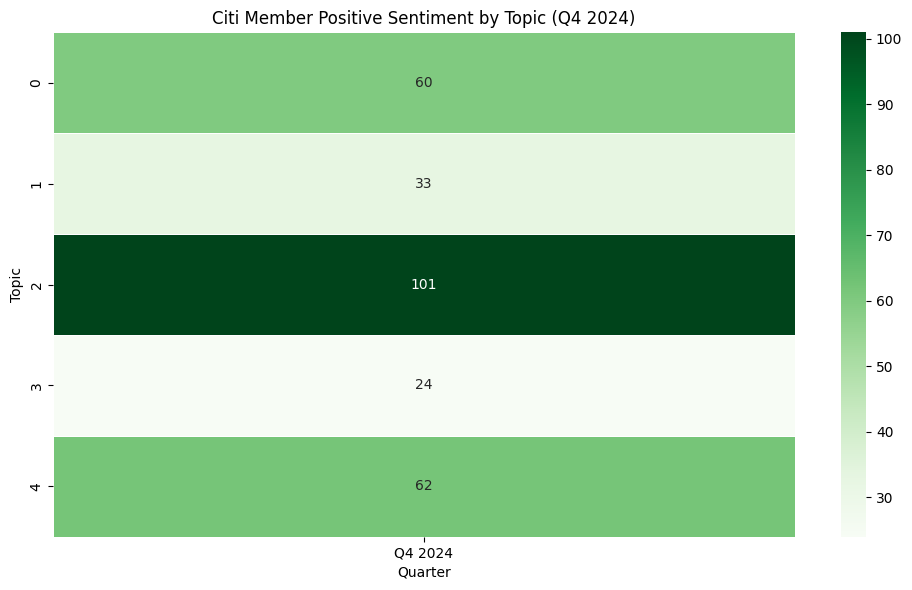

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap for Citi member positive sentiment
plt.figure(figsize=(10, 6))
sns.heatmap(
    latest_data.pivot(index='topic', columns='quarter_year', values='positive_yes'),
    annot=True, fmt="d", cmap="Greens", linewidths=0.5
)
plt.title(f"Citi Member Positive Sentiment by Topic ({latest_q})")
plt.ylabel("Topic")
plt.xlabel("Quarter")
plt.tight_layout()
plt.show()



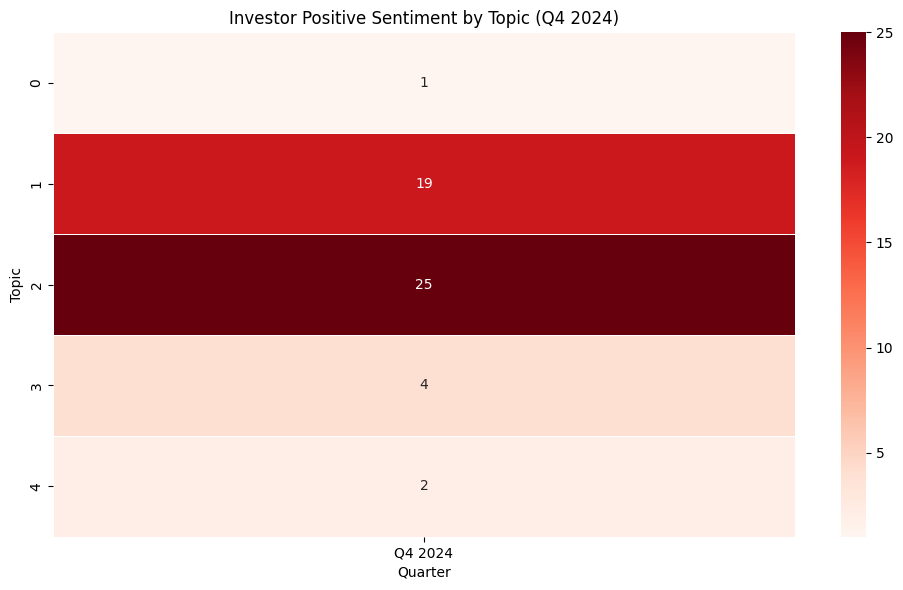

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    latest_data.pivot(index='topic', columns='quarter_year', values='positive_no'),
    annot=True, fmt="d", cmap="Reds", linewidths=0.5
)
plt.title(f"Investor Positive Sentiment by Topic ({latest_q})")
plt.ylabel("Topic")
plt.xlabel("Quarter")
plt.tight_layout()
plt.show()


In [39]:
keywords_citi_positive = [
    "strong", "improved", "confident", "solid", "healthy",
    "resilient", "progress", "growth", "momentum", "record",
    "continued", "positive", "encouraging", "optimistic"
]

keywords_investor_negative = [
    "concern", "worried", "unclear", "challenging", "risk",
    "pressure", "uncertainty", "decline", "downturn", "volatility",
    "cautious", "issues", "slowdown", "softness", "question"
]

df['citi_positive_flag'] = df.apply(
    lambda row: any(k in str(row['sentence']).lower() for k in keywords_citi_positive) if row['is_citi_member'].lower() == 'yes' else False,
    axis=1
)

df['investor_negative_flag'] = df.apply(
    lambda row: any(k in str(row['sentence']).lower() for k in keywords_investor_negative) if row['is_citi_member'].lower() == 'no' else False,
    axis=1
)


In [42]:
contradictions = df.groupby(['quarter', 'year', 'topic']).agg(
    citi_positive=('citi_positive_flag', 'sum'),
    investor_negative=('investor_negative_flag', 'sum')
).reset_index()

contradictions['quarter_year'] = contradictions['quarter'] + ' ' + contradictions['year'].astype(str)
contradictions['contradiction'] = (contradictions['citi_positive'] > 0) & (contradictions['investor_negative'] > 0)
contradictions_with_issues = contradictions[contradictions['contradiction'] == True].copy()
topic_labels = {
    0: "Liquidity & Deposits",
    1: "Capital Adequacy & Buffers",
    2: "Credit Risk & Loan Quality",
    3: "Macroeconomic Environment",
    4: "Stress Testing & Regulation"
}
contradictions_with_issues.loc[:,'topic_label'] = contradictions_with_issues['topic'].map(topic_labels)


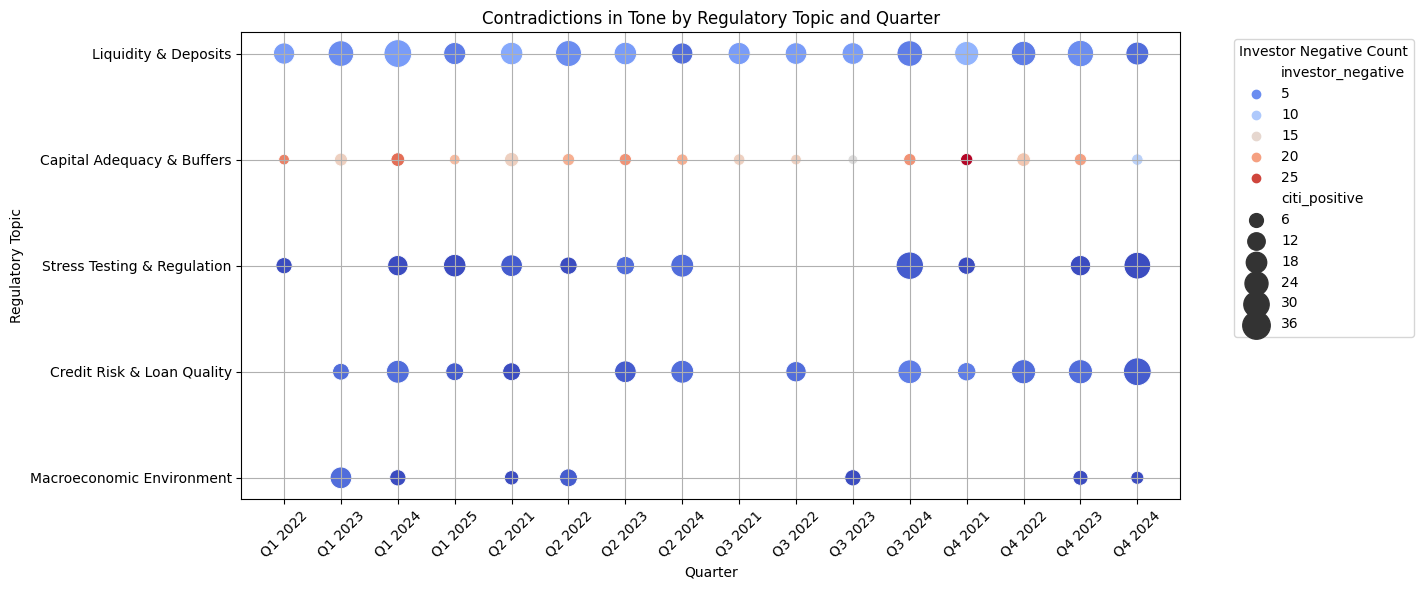

In [43]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=contradictions_with_issues,
    x='quarter_year',
    y='topic_label',
    size='citi_positive',
    hue='investor_negative',
    palette='coolwarm',
    sizes=(50, 400),
    legend='brief'
)

plt.title("Contradictions in Tone by Regulatory Topic and Quarter")
plt.xlabel("Quarter")
plt.ylabel("Regulatory Topic")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Investor Negative Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
